         age                                                    
       count       mean        std   min   25%   50%   75%   max
set                                                             
test   103.0  33.466019  12.809935  14.0  23.5  31.0  41.0  66.0
train  410.0  33.068293  12.562225  15.0  22.0  29.0  43.0  65.0
           age
set   sex     
test  0.0   65
      1.0   38
train 0.0  257
      1.0  153


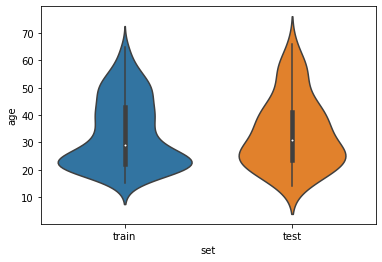

In [196]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = pd.concat([participants_train, participants_test])

sns.violinplot(x="set", y="age", data=participants)
print(participants[["age", "set"]].groupby("set").describe())
print(participants[["set", "sex", "age"]].groupby(["set", "sex"]).count())

In [197]:
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois = pd.concat([rois_train, rois_test])

                 sum_sq     df          F        PR(>F)
diagnosis   2606.207928    1.0  29.245287  9.808873e-08
Residual   45538.013350  511.0        NaN           NaN
                 sum_sq     df          F    PR(>F)
diagnosis    791.094363    1.0  10.876419  0.001042
Residual   37167.493121  511.0        NaN       NaN


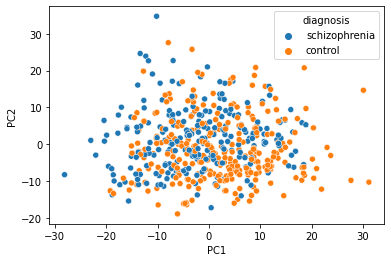

In [198]:
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

PCs = PCA(n_components=2).fit_transform(rois)
participants['PC1'], participants['PC2']  = PCs[:, 0], PCs[:, 1]

sns.scatterplot (x="PC1", y="PC2", hue="diagnosis",  data=participants)
oneway = smf.ols('PC1 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))
oneway = smf.ols('PC2 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))

In [199]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
import problem
import datetime as dt
from datetime import datetime 

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [200]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

assert X_train.shape[1] == 284 + 331695

In [201]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score,StratifiedGroupKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_fscore_support

In [202]:
# Seperating ROI and VBM data from X_train

x_train_roi = X_train[:,:284]
x_train_vbm = X_train[:, 284:]
y_train = y_train

x_test_roi = X_test[:,:284]
x_test_vbm = X_test[:, 284:]
y_test = y_test

In [203]:
# Creating cross-validation group for Stratified-CV
train_group = participants.sex[participants.set=='train']
test_group = participants.sex[participants.set=='test']

In [204]:
#### Common cross-validation for three models (ROI data) ####

ml_models = [SVC, LogisticRegression, RandomForestClassifier]


for model in ml_models:
    print("Model: ", model )
    start_time = dt.datetime.now()
    
    if model == LogisticRegression:
        param_grid = {'C': [1e-1, 1, 10, 100],
                     'penalty': ['l2']}
    elif model == SVC:
        param_grid = {'kernel': ('linear', 'rbf'),
                      'C': [0.001,0.1,1,10,100]}  
        
    elif model == RandomForestClassifier :
        param_grid = {'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, 40],
        'min_samples_split': [2, 5, 10, 50],
        'min_samples_leaf': [1, 2, 4]}
     

    cv = 5 
    
    grid_search = GridSearchCV( model(), param_grid, scoring='f1_weighted', cv=cv, error_score='raise')
    grid_search.fit(x_train_roi, y_train)
    
    param_tuning_time = dt.datetime.now() - start_time
    print("Hyperparameter Tuning time: %s seconds" % param_tuning_time ) 
    
    # Print the best parameters
    print("Best parameters: ", grid_search.best_params_)
    
    # Train the model on the best parameters
    best_model = model().__class__(**grid_search.best_params_)
    best_model.fit(x_train_roi, y_train)

    model_training_time = dt.datetime.now() - start_time
    print("Training time: %s seconds" % model_training_time )  #For training time
    
    # Predict on the testing set using the best model
    y_pred = best_model.predict(x_test_roi)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print("Test set score Precision, Recall, f1_score: ", precision, recall, f1_score)


Model:  <class 'sklearn.svm._classes.SVC'>
Hyperparameter Tuning time: 0:00:02.555670 seconds
Best parameters:  {'C': 10, 'kernel': 'rbf'}
Training time: 0:00:02.571555 seconds
Test set score Precision, Recall, f1_score:  0.6813970313666915 0.6796116504854369 0.6751553651256285
Model:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Hyperparameter Tuning time: 0:00:00.585162 seconds
Best parameters:  {'C': 0.1, 'penalty': 'l2'}
Training time: 0:00:00.618247 seconds
Test set score Precision, Recall, f1_score:  0.7709105001223789 0.7572815533980582 0.7511000668551545
Model:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Hyperparameter Tuning time: 0:02:47.672661 seconds
Best parameters:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Training time: 0:02:47.783920 seconds
Test set score Precision, Recall, f1_score:  0.7281553398058253 0.7281553398058253 0.7281553398058253


In [211]:
#### Common cross-validation for three models (VBM Data) ####

ml_models = [SVC, LogisticRegression,RandomForestClassifier]


for model in ml_models:
    print("Model: ", model ) 
    start_time = dt.datetime.now()
    #print("Start time: %s seconds" % start_time)
    
    if model == LogisticRegression:
        param_grid = {'C': [1e-1, 1, 10, 100],
                     'penalty': ['l2']}
    elif model == SVC:
        param_grid = {'kernel': ('linear', 'rbf'),
                      'C': [0.001,0.1,1,10,100]} 

    elif model == RandomForestClassifier :
            param_grid = {'n_estimators': [20, 30, 50],
            'max_depth': [10, 20, 30, 40],
            'min_samples_split': [2, 5, 10, 50],
            'min_samples_leaf': [1, 2, 4]}
             

    cv = 5 
    
    grid_search = GridSearchCV( model(), param_grid, scoring='f1_weighted', cv=cv, error_score='raise')
    grid_search.fit(x_train_vbm, y_train)
    param_tuning_time = dt.datetime.now() - start_time
    print("Hyperparemeter time: %s seconds" % param_tuning_time ) 
    # Print the best parameters
    print("Best parameters: ", grid_search.best_params_)
    
    # Train the model on the best parameters
    best_model = model().__class__(**grid_search.best_params_)
    best_model.fit(x_train_vbm, y_train)

    model_training_time = dt.datetime.now() - start_time
    print("Training time: %s seconds" % model_training_time )  #For training time
    
    
    # Predict on the testing set using the best model
    y_pred = best_model.predict(x_test_vbm)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print("Test set score Precision, Recall, f1_score: ", precision, recall, f1_score)


Model:  <class 'sklearn.svm._classes.SVC'>
Hyperparemeter time: 0:25:36.168606 seconds
Best parameters:  {'C': 0.001, 'kernel': 'linear'}
Training time: 0:26:08.032200 seconds
Test set score Precision, Recall, f1_score:  0.6834601591883145 0.6796116504854369 0.673443746430611
Model:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Hyperparemeter time: 0:05:22.781747 seconds
Best parameters:  {'C': 100, 'penalty': 'l2'}
Training time: 0:05:39.801408 seconds
Test set score Precision, Recall, f1_score:  0.7200936938726524 0.7087378640776699 0.7003162405567057
Model:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Hyperparemeter time: 0:51:58.934889 seconds
Best parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
Training time: 0:52:00.483367 seconds
Test set score Precision, Recall, f1_score:  0.5401335237906091 0.5436893203883495 0.5393948378567119


In [207]:
#### Stratified Group cross-validation for three models (ROI Data) ####

ml_models = [SVC, LogisticRegression,RandomForestClassifier]


for model in ml_models:
    print("Model: ",  model)
    start_time = dt.datetime.now()
    
    if model == LogisticRegression:
        param_grid = {'C': [1e-1, 1, 10, 100],
                     'penalty': ['l2']}
    elif model == SVC:
        param_grid = {'kernel': ('linear', 'rbf'),
                      'C': [0.001,0.1,1,10,100]}  
        
    elif model == RandomForestClassifier :
        param_grid = {'n_estimators': [50, 70, 100],
        'max_depth': [10, 20, 30, 40],
        'min_samples_split': [2, 5, 10, 50],
        'min_samples_leaf': [1, 2, 4]} 
    
    cv = StratifiedGroupKFold(n_splits=2)
    
    grid_search = GridSearchCV( model(), param_grid, scoring='f1_weighted', cv=cv.split(x_train_roi, y_train, train_group), error_score='raise')
    grid_search.fit(x_train_roi, y_train)
    param_tuning_time = dt.datetime.now() - start_time
    print("Hyper Tuning time: %s seconds" % param_tuning_time ) 
    print("Best parameters: ", grid_search.best_params_)
    
    # Train the model on the best parameters
    best_model = model().__class__(**grid_search.best_params_)
    best_model.fit(x_train_roi, y_train)
    
    model_training_time = dt.datetime.now() - start_time
    print("Training time: %s seconds" % model_training_time )  #For training time    
 
    # Predict on the testing set using the best model
    y_pred = best_model.predict(x_test_roi)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print("Test set score Precision, Recall, f1_score: ", precision, recall, f1_score)


Model:  <class 'sklearn.svm._classes.SVC'>
Hyper Tuning time: 0:00:00.337578 seconds
Best parameters:  {'C': 100, 'kernel': 'rbf'}
Training time: 0:00:00.351071 seconds
Test set score Precision, Recall, f1_score:  0.721982356235997 0.7184466019417476 0.7145304723831281
Model:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Hyper Tuning time: 0:00:00.242854 seconds
Best parameters:  {'C': 0.1, 'penalty': 'l2'}
Training time: 0:00:00.276446 seconds
Test set score Precision, Recall, f1_score:  0.7709105001223789 0.7572815533980582 0.7511000668551545
Model:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Hyper Tuning time: 0:00:29.342171 seconds
Best parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 50, 'n_estimators': 50}
Training time: 0:00:29.447866 seconds
Test set score Precision, Recall, f1_score:  0.7203026841804683 0.7184466019417476 0.7187655522652348


In [212]:
#### Stratified Group cross-validation for three models (VBM Data) ####

ml_models = [SVC, LogisticRegression,RandomForestClassifier]


for model in ml_models:
    print("Model: ", model )
    start_time = dt.datetime.now()
    #print("Start time: %s seconds" % start_time)

    if model == LogisticRegression:
        param_grid = {'C': [1e-1, 1, 10, 100],
                     'penalty': ['l2']}
    elif model == SVC:
        param_grid = {'kernel': ('linear', 'rbf'),
                      'C': [0.001,0.1,1,10,100]}  


    elif model == RandomForestClassifier :
        param_grid = {'n_estimators': [20, 30, 50],
        'max_depth': [10, 20, 30, 40],
        'min_samples_split': [2, 5, 10, 50],
        'min_samples_leaf': [1, 2, 4]}

    cv = StratifiedGroupKFold(n_splits=2)
    
    grid_search = GridSearchCV( model(), param_grid, scoring='f1_weighted', cv=cv.split(x_train_vbm, y_train, train_group), error_score='raise')
    grid_search.fit(x_train_vbm, y_train)
    param_tuning_time = dt.datetime.now() - start_time
    print("Hyperparameter Tuning time: %s seconds" % param_tuning_time ) 
    print("Best parameters: ", grid_search.best_params_)
    
    # Train the model on the best parameters
    best_model = model().__class__(**grid_search.best_params_)
    best_model.fit(x_train_vbm, y_train)
    
    model_training_time = dt.datetime.now() - start_time
    print("Training time: %s seconds" % model_training_time )  #For training time
    
    # Predict on the testing set using the best model
    y_pred = best_model.predict(x_test_vbm)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print("Test set score Precision, Recall, f1_score: ", precision, recall, f1_score)


Model:  <class 'sklearn.svm._classes.SVC'>
Hyperparameter Tuning time: 0:08:19.988869 seconds
Best parameters:  {'C': 10, 'kernel': 'rbf'}
Training time: 0:08:51.213808 seconds
Test set score Precision, Recall, f1_score:  0.7074080117483886 0.6990291262135923 0.6913640829003916
Model:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Hyperparameter Tuning time: 0:01:54.584325 seconds
Best parameters:  {'C': 10, 'penalty': 'l2'}
Training time: 0:02:12.148581 seconds
Test set score Precision, Recall, f1_score:  0.7200936938726524 0.7087378640776699 0.7003162405567057
Model:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Hyperparameter Tuning time: 0:17:33.607098 seconds
Best parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 20}
Training time: 0:17:34.827560 seconds
Test set score Precision, Recall, f1_score:  0.718067180002232 0.7184466019417476 0.7176428525895973


In [242]:
## Time taken for model (computational cost) run collected from above code

roi_cv_time_taken = pd.DataFrame([[0.0425,0.0428],[0.0097,0.01],[2.794, 2.798]], columns=['Hyperparameter Tuning Time','Total Time'], index=['SVC','LogR','RF'])
vbm_cv_time_taken = pd.DataFrame([[25.6,26.13],[5.37,5.65],[51.96,52]], columns=['Hyperparameter Tuning Time','Total Time'], index=['SVC','LogR','RF'])
roi_gscv_time_taken = pd.DataFrame([[0.005,0.0058],[0.004,0.0046],[0.489,0.490]], columns=['Hyperparameter Tuning Time','Total Time'], index=['SVC','LogR','RF'])
vbm_gscv_time_taken = pd.DataFrame([[8.33,8.85],[1.9,2.2],[17.56,17.58]], columns=['Hyperparameter Tuning Time','Total Time'], index=['SVC','LogR','RF'])

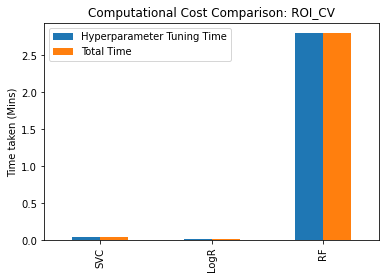

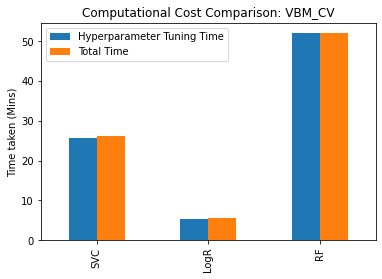

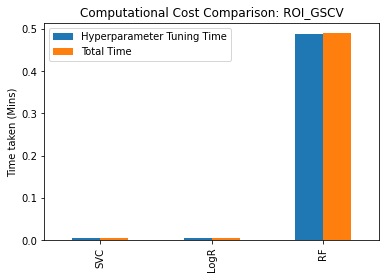

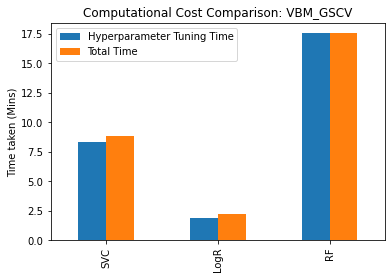

In [263]:
## Plotting total time taken for each model
time_taken = [roi_cv_time_taken,vbm_cv_time_taken,roi_gscv_time_taken,vbm_gscv_time_taken]
titles = ['ROI_CV','VBM_CV','ROI_GSCV','VBM_GSCV']


for i in range(len(time_taken)):
    time_taken[i].plot(kind='bar')
    plt.title(f'Computational Cost Comparison: {titles[i]}')
    plt.ylabel('Time taken (Mins)')
plt.show()


In [270]:
## Collecting performance metric values from above models

roi_cv = pd.DataFrame([[0.6814, 0.6796, 0.6752],[0.7709, 0.7572, 0.7511],[0.7281, 0.7281, 0.7281]], index =['Precision','Recall','F1'], columns = ['SVC','LogR','RF'])
vbm_cv = pd.DataFrame([[0.6834, 0.6796, 0.6734],[0.7201, 0.7087, 0.7003],[0.5401, 0.5436, 0.5393]], index =['Precision','Recall','F1'], columns = ['SVC','LogR','RF'])
roi_gscv = pd.DataFrame([[0.7219, 0.7184, 0.7145],[0.7709, 0.7572, 0.7511],[0.7203, 0.7184, 0.7187]], index =['Precision','Recall','F1'], columns = ['SVC','LogR','RF'])
vbm_gscv  = pd.DataFrame([[0.7074, 0.6990, 0.6913],[0.7201, 0.7087, 0.7003],[0.7180, 0.7184, 0.7176]], index =['Precision','Recall','F1'], columns = ['SVC','LogR','RF'])

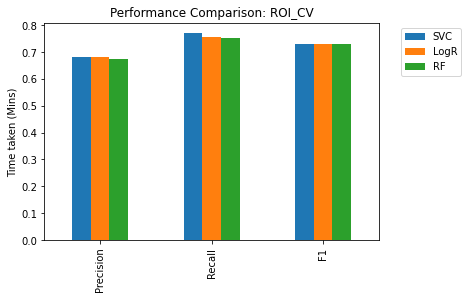

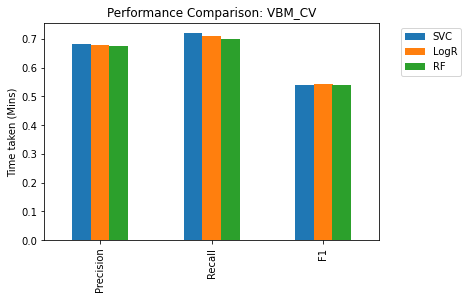

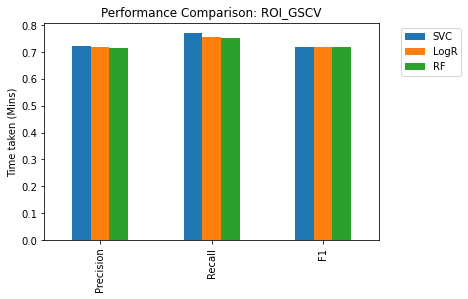

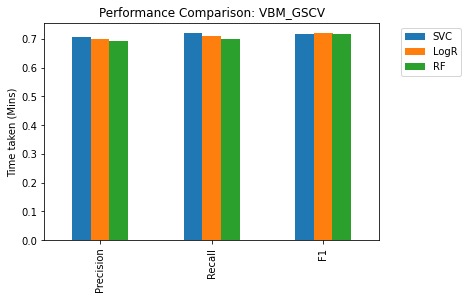

In [271]:
## Plotting model performances

performance = [roi_cv,vbm_cv,roi_gscv,vbm_gscv]
titles = ['ROI_CV','VBM_CV','ROI_GSCV','VBM_GSCV']


for i in range(len(performance)):
    performance[i].plot(kind='bar')
    plt.title(f'Performance Comparison: {titles[i]}')
    plt.ylabel('Time taken (Mins)')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()